# Appendix
https://en.wikipedia.org/wiki/2048_(video_game)
https://www.geeksforgeeks.org/2048-game-in-python/

problem statement : https://drive.google.com/file/d/1-l9t-sKYWD_hrAAmfzJFmv2X151lMsEo/view?usp=drive_link

IMPLEMENTED GAME
4X4 GRID (implemented as a numpy grid)
4 switches to move all up/all down /all right /all left
(moves with the keyboard up/l/d/r buttons)


## game user manual
i desgned first the basic version of the game with help of the given regulations
then i added the required moves counter to show the number of moves taken

on playing i realized to add an undo feature to go back and check out other possibiities in each game
(which works by clicking z) , and to not waste space i have ensured maximum 5 undo's
and also escape button works as to exit the game

while implementing algorithms one by one was tidous and time consuming , also made no relation to each other
the class created for each framework , keeps the logic seperate , ease of readability and works with the following keys
1 : approach 1
2: approach 2
so on , and also note that the undo feature resets the board to the point where algorithm didnt work , if used any algorithm , and space bar , helps to stop the ai working and continues the manual use of the game

## workflow
![alt text](https://github.com/agarwalsoham993/quant_club/blob/main/image.png?raw=1)

# libraries

In [5]:
import pygame
import random
from math import log
import numpy as np
import warnings

pygame 2.6.1 (SDL 2.28.4, Python 3.11.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


# scoring
## Predictive merge score
counts if  there is a possible merge and how many , trying to implement that , because in most of the logic i had to try to implement this same algorithm where we find the possible no of merges , this will help in creating a smoother gaming code , and we can use it any time

In [1]:
# in game2048 class
# def calculate_merge_score(self):
#         rows = len(self.board)
#         cols = len(self.board[0])
#         merge_score = 0

#         # Check for possible merges horizontally
#         for row in range(rows):
#             for col in range(cols - 1):
#                 if self.board[row][col] != 0 and self.board[row][col] == self.board[row][col + 1]:
#                     merge_score += 1

#         # Check for possible merges vertically
#         for col in range(cols):
#             for row in range(rows - 1):
#                 if self.board[row][col] != 0 and self.board[row][col] == self.board[row + 1][col]:
#                     merge_score += 1
#         return merge_score

# game class

In [9]:
# --- Constants ---
GRID_SIZE = 4
TILE_SIZE = 100
MARGIN = 10
WIDTH = (TILE_SIZE + MARGIN) * GRID_SIZE
HEIGHT = (TILE_SIZE + MARGIN) * GRID_SIZE + 50 #Added 50 for moves display
FPS = 30
algo_move_interval = 125  # seconds
k =4  #number of algorithms
k1 = 0.5
k2 = 0.5

# Colors
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
GRAY = (200, 200, 200)

TILE_COLORS = {
    x: ((255 - 15*(log(x)/log(2))),255,(255 - 15*(log(x)/log(2)))) for x in [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
}
TILE_COLORS[0] = GRAY  # Gray for empty tiles


In [10]:
class Game2048:
    def __init__(self, size=GRID_SIZE):
        self.size = size
        self.board = np.zeros((self.size, self.size), dtype=int)
        self.moves = 0
        self.add_new_tile()
        self.add_new_tile()
        self.game_over = False
        self.has_won = False
        self.merge_count = 0  # Count of merges made during the game
        self.score = 0  # Score of the game

        self.history = History(self)

        self.algo_on = False
        self.algorithm = None  # algorithm object (set later)

        # dictionary of approaches

        self.approaches = {i: globals()[f"approach{i+1}"] for i in range(k)}

        self.algo_keys = [getattr(pygame, f"K_{i}") for i in range(1, k + 1)]  # List of keys for approaches

        self.algo_index = 0  # Start with the first approach

    def add_new_tile(self):
        empty_cells = np.argwhere(self.board == 0)
        if empty_cells.size > 0:
            i, j = random.choice(empty_cells)
            self.board[i, j] = 2 if random.random() < 0.9 else 4

    def transpose(self):
        self.board = np.transpose(self.board)

    def reverse(self):
        for i in range(self.size):
            self.board[i] = np.flip(self.board[i])

    def slide(self, row):
        row = row[row != 0]
        return np.pad(row, (0, self.size - len(row)), 'constant')

    def merge(self, row):
        row = row.copy()
        i = 0
        while i < self.size - 1:
            if row[i] == row[i + 1] and row[i] != 0:
                self.merge_count += 1
                row[i] *= 2
                row[i + 1] = 0
                i += 1
            i += 1
        return row

    def move_left(self):
        moved = False
        old_board = np.copy(self.board)
        for i in range(self.size):
            original_row = self.board[i].copy()
            row = self.slide(original_row)
            row = self.merge(row)
            row = self.slide(row)
            if not np.array_equal(row, original_row):
                moved = True
            self.board[i] = row
        if not moved:
            self.board = old_board
        return moved

    def move_right(self):
        old_board = np.copy(self.board)
        self.reverse()
        moved = self.move_left()
        self.reverse()
        if not moved:
            self.board = old_board
        return moved

    def move_up(self):
        old_board = np.copy(self.board)
        self.transpose()
        moved = self.move_left()
        self.transpose()
        if not moved:
            self.board = old_board
        return moved

    def move_down(self):
        old_board = np.copy(self.board)
        self.transpose()
        moved = self.move_right()
        self.transpose()
        if not moved:
            self.board = old_board
        return moved

    def is_game_over(self):
        for i in range(self.size):
            for j in range(self.size):
                if self.board[i][j] == 0:
                    return False
                if i < self.size - 1 and self.board[i][j] == self.board[i + 1][j]:
                    return False
                if j < self.size - 1 and self.board[i][j] == self.board[i][j + 1]:
                    return False
        return True

    def check_win(self):
        return np.any(self.board == 2048)

    def calculate_merge_score(self):
        rows = len(self.board)
        cols = len(self.board[0])
        merge_score = 0

        # predict for possible merges horizontally
        for row in range(rows):
            for col in range(cols - 1):
                if self.board[row][col] != 0 and self.board[row][col] == self.board[row][col + 1]:
                    merge_score += 1

        # predict for possible merges vertically
        for col in range(cols):
            for row in range(rows - 1):
                if self.board[row][col] != 0 and self.board[row][col] == self.board[row + 1][col]:
                    merge_score += 1
        return merge_score


    def input(self, key):
        old_board = self.board.copy()

        if key == pygame.K_UP:
            moved = self.move_up()

        elif key == pygame.K_DOWN:
            moved = self.move_down()

        elif key == pygame.K_LEFT:
            moved = self.move_left()

        elif key == pygame.K_RIGHT:
            moved = self.move_right()
        else:
            moved = False

        if not np.array_equal(old_board, self.board):
            self.moves += 1
            self.add_new_tile()

            pms_score = self.calculate_merge_score()
            self.score += pms_score

            if self.algo_on == False:                   # to avoid saving while we have algorithm on , to reset board only once
                self.history.save_state()

            if self.is_game_over():
                self.game_over = True
            if self.check_win():
                self.has_won = True

# algorithms
i am creating a general structured framework of class which can be followed to give out the required set of output move , so as to reach the end , i am trying many different ( even most general approach up can be mathematically derived )

but general basic idea remains to
#### Develop a strategy that minimizes the number of moves required to reach the 2048 tile.
Consider heuristics such as prioritizing merges, maintaining a structured board, or maximizing high-value tile placement.

approach 1:
 calculate the sum of all the number in the grid for each of the four move and then compare bigger and take that step
 if two have same sum , then compare for max of (sum of next operations ) and then taking that step

In [11]:
class approach1:
    def __init__(self, game):
        self.game = game

    def calculate_board_sum(self, board):
        return np.sum(board)

    def choose_best_move(self):
        best_move = None
        best_sum = -1
        original_board = self.game.board.copy()

        for move in [pygame.K_UP, pygame.K_DOWN, pygame.K_LEFT, pygame.K_RIGHT]:
            simulated_board = self.game.board.copy()

            if move == pygame.K_UP:
                moved = self.game.move_up()
            elif move == pygame.K_DOWN:
                moved = self.game.move_down()
            elif move == pygame.K_LEFT:
                moved = self.game.move_left()
            elif move == pygame.K_RIGHT:
                moved = self.game.move_right()
            else:
                moved = False

            if moved:
                current_sum = self.calculate_board_sum(self.game.board)
                if current_sum > best_sum:
                    best_sum = current_sum
                    best_move = move

            self.game.board = simulated_board  # Reset board to original

        return best_move


approach 2
to go for the next move such that the next step has the highest number (focuses on the merging)

In [12]:
class approach2:
    def __init__(self, game):
        self.game = game

    def calculate_max_tile(self, board):
        return np.max(board)

    def choose_best_move(self):
        best_move = None
        best_max_tile = -1
        original_board = self.game.board.copy()

        for move in [pygame.K_UP, pygame.K_DOWN, pygame.K_LEFT, pygame.K_RIGHT]:
            simulated_board = self.game.board.copy()

            if move == pygame.K_UP:
                moved = self.game.move_up()
            elif move == pygame.K_DOWN:
                moved = self.game.move_down()
            elif move == pygame.K_LEFT:
                moved = self.game.move_left()
            elif move == pygame.K_RIGHT:
                moved = self.game.move_right()
            else:
                moved = False

            if moved:
                current_max_tile = self.calculate_max_tile(self.game.board)
                if current_max_tile > best_max_tile:
                    best_max_tile = current_max_tile
                    best_move = move

            self.game.board = simulated_board

        return best_move


approach 3 : maximizing numbers of empty spaces in the board ( indirectly focusing on merging)

In [13]:
class approach3:

    def __init__(self, game):
        self.game = game

    def calculate_empty_cells(self, board):
        return np.sum(board == 0)

    def choose_best_move(self):
        best_move = None
        best_empty_count = -1
        original_board = self.game.board.copy()

        for move in [pygame.K_UP, pygame.K_DOWN, pygame.K_LEFT, pygame.K_RIGHT]:
            simulated_board = self.game.board.copy()

            if move == pygame.K_UP:
                moved = self.game.move_up()
            elif move == pygame.K_DOWN:
                moved = self.game.move_down()
            elif move == pygame.K_LEFT:
                moved = self.game.move_left()
            elif move == pygame.K_RIGHT:
                moved = self.game.move_right()
            else:
                moved = False

            if moved:
                current_empty_count = self.calculate_empty_cells(self.game.board)
                if current_empty_count > best_empty_count:
                    best_empty_count = current_empty_count
                    best_move = move

            self.game.board = simulated_board

        return best_move


approach 4 : direct approach for maximizing the number of merges , for this i had to add a merge counter in the base framework of game2046 , which leads to use of merge count to maximize the number of merges taking place by that move during simulation

In [14]:
class approach4:
    def __init__(self, game):
        self.game = game

    def calculate_merge_count(self, board_before, board_after):
        non_zero_before = np.count_nonzero(board_before)
        non_zero_after = np.count_nonzero(board_after)
        return non_zero_before - non_zero_after

    def choose_best_move(self):
        best_move = None
        max_merge_count = -1
        original_board = self.game.board.copy()

        for move in [pygame.K_UP, pygame.K_DOWN, pygame.K_LEFT, pygame.K_RIGHT]:
            simulated_board_before = self.game.board.copy()

            if move == pygame.K_UP:
                moved = self.game.move_up()
            elif move == pygame.K_DOWN:
                moved = self.game.move_down()
            elif move == pygame.K_LEFT:
                moved = self.game.move_left()
            elif move == pygame.K_RIGHT:
                moved = self.game.move_right()
            else:
                moved = False

            if moved:
                simulated_board_after = self.game.board.copy()
                merge_count = self.calculate_merge_count(simulated_board_before, simulated_board_after)

                if merge_count > max_merge_count:
                    max_merge_count = merge_count
                    best_move = move

            self.game.board = original_board.copy()

        return best_move


## undo feature

In [15]:
class History:
    def __init__(self, game):
        self.game = game
        self.states = []
        self.algo_board_saved = False

    def save_state(self):
        self.states.append((np.copy(self.game.board), self.game.moves))
        if len(self.states) > 5:
            self.states.pop(0)

    def save_pre_algo(self):
        if not self.algo_board_saved:
            self.save_state()
            self.algo_board_saved = True

    def undo(self):
        if self.states:
            self.game.board, self.game.moves = self.states.pop()
            self.game.game_over = False
            self.game.has_won = False
            self.algo_board_saved = False


# pygame

In [16]:
pygame.init()
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("2048")
clock = pygame.time.Clock()
font = pygame.font.Font(None, 40)
large_font = pygame.font.Font(None, 80)

game = Game2048()
game.algorithm = game.approaches[game.algo_index](game)
running = True
algo_move_timer = 0

warnings.filterwarnings("ignore")

In [ ]:
while running:
    clock.tick(FPS)
    #user input interaction
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        if event.type == pygame.KEYDOWN:
            if game.has_won:
                running = False

            elif event.key in game.algo_keys:
                if not game.history.algo_board_saved:
                    game.history.save_pre_algo()

                game.algo_index = game.algo_keys.index(event.key)
                game.algorithm = game.approaches[game.algo_index](game)
                game.algo_on = True

            elif event.key == pygame.K_ESCAPE:
                running = False

            elif event.key == pygame.K_SPACE:
                game.algo_on = False
            elif event.key == pygame.K_z:
                game.history.undo()
            else:
                game.input(event.key)

    if game.algo_on and not (game.game_over or game.has_won) and game.algorithm:
        current_time = pygame.time.get_ticks()
        if current_time - algo_move_timer > algo_move_interval:
            algo_move_timer = current_time
            best_move = game.algorithm.choose_best_move()
            if best_move:
                game.input(best_move)

    screen.fill(WHITE)

    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            value = game.board[i][j]
            color = TILE_COLORS.get(value, GRAY)
            rect = pygame.Rect(j * (TILE_SIZE + MARGIN) + MARGIN,
                               i * (TILE_SIZE + MARGIN) + MARGIN,
                               TILE_SIZE, TILE_SIZE)
            pygame.draw.rect(screen, color, rect)
            if value != 0:
                text = font.render(str(value), True, BLACK)
                text_rect = text.get_rect(center=rect.center)
                screen.blit(text, text_rect)

    moves_text = font.render(f"Moves: {game.moves}", True, BLACK)
    moves_rect = moves_text.get_rect(center=(WIDTH // 4, HEIGHT - 25))
    screen.blit(moves_text, moves_rect)

    approach_print = font.render(f"Approach {game.algo_index + 1}" if game.algo_on else "MANUAL", True, BLACK)
    algo_place = approach_print.get_rect(center=(3*WIDTH // 4, HEIGHT - 25))
    screen.blit(approach_print, algo_place)

    if game.game_over:
        game_over_text = font.render("Game Over!", True, BLACK)
        game_over_rect = game_over_text.get_rect(center=(WIDTH // 2, HEIGHT // 2))
        screen.blit(game_over_text, game_over_rect)

    if game.has_won:
        win_text = large_font.render("You Win!", True, BLACK)
        win_rect = win_text.get_rect(center=(WIDTH // 2, HEIGHT // 2))
        screen.blit(win_text, win_rect)

    pygame.display.flip()

pygame.quit()


KeyboardInterrupt: 

# EFFECIENCY METRIC

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## metric 1
Calculate the highest tile obtained in n runs
Calculate the average of max_no of merges carried out

In [18]:
def max_tile(approach_idx, num_iterations=10):
    '''no of approach {1,2,3..},no of iterations = default 10 '''
    max_tile = []

    for x in range(num_iterations):
        game = Game2048()
        approach = game.approaches[approach_idx-1](game)

        while not game.game_over:
            best_move = approach.choose_best_move()
            if best_move:
                game.input(best_move)
        max_tile.append(np.max(game.board))

    return max_tile


In [20]:
tr1 = max_tile(1)
print(tr1)

[np.int64(64), np.int64(128), np.int64(32), np.int64(128), np.int64(64), np.int64(128), np.int64(64), np.int64(64), np.int64(128), np.int64(64)]


calculate the highest score reached in each operation

In [22]:
def max_score(approach_idx, num_iterations=10):
    '''no of approach {1,2,3..},no of iterations = default 10 '''

    scores = []

    for x in range(num_iterations):
        game = Game2048()
        approach = game.approaches[approach_idx-1](game)

        while not game.game_over:
            best_move = approach.choose_best_move()
            if best_move:
                game.input(best_move)

            if game.has_won:
                scores.append(-1)
                break

        if not game.has_won:
            scores.append(game.score)

    return scores


In [23]:
tr2 = max_score(1)
print(tr2)

[184, 86, 363, 114, 149, 213, 242, 273, 110, 465]


lets combine them to reduce time complexity

In [36]:
def effeciency(approach_idx, num_iterations=10):
    max_scores = []
    max_tile = []

    for x in range(num_iterations):
        game = Game2048()
        approach = game.approaches[approach_idx-1](game)

        while not game.game_over:
            best_move = approach.choose_best_move()

            if best_move:
                game.input(best_move)

            if game.has_won:
                max_scores.append(-1)
                break

        max_tile.append(int(np.max(game.board)))

        if not game.has_won:
            max_scores.append(game.score)

    idx1 = [c for c in range(num_iterations) if max_scores[c]==max(max_scores)]
    idx2 = [a for a in range(num_iterations) if max_tile[a]== max(max_tile)]

    return max(max_scores), max(max_tile) , idx1 , idx2

In [38]:
t3 = effeciency(1)
t3

(408, 128, [3], [3, 6, 7])

In [ ]:
# for each 10 iterations it takes around 1sec


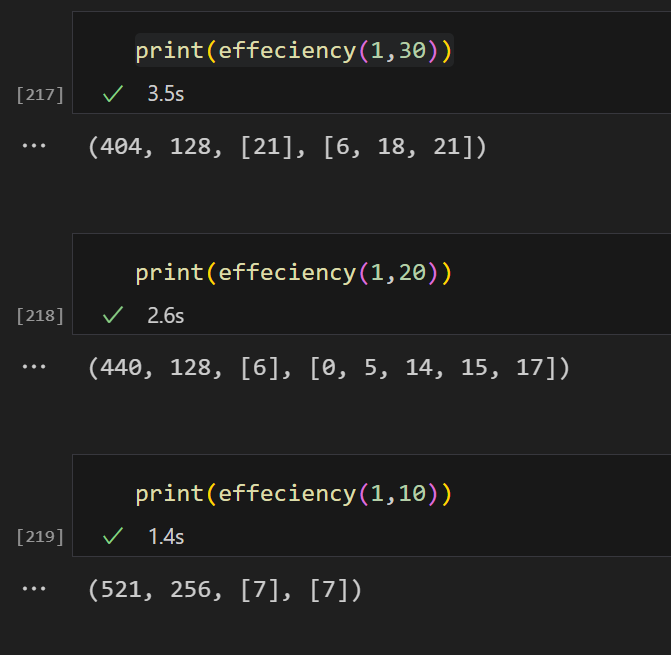